### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [2]:
df = pd.read_csv('pair_trade.csv')

In [3]:
df.drop(columns = "Date",inplace = True)
df['lrets_a1'] = np.log(df['Asset1']/df['Asset1'].shift(1))
df['lrets_a2'] = np.log(df['Asset2']/df['Asset2'].shift(1))
df['lrets_a1_roll'] = df['lrets_a1'].rolling(window=21).mean()
df['lrets_a2_roll'] = df['lrets_a2'].rolling(window=21).mean()


In [4]:
df['a1_prod_rets'] = df['lrets_a1'].cumsum()
df['a2_prod_rets'] = df['lrets_a2'].cumsum()


In [5]:
df["a1_sum_rets"] = df['lrets_a1'].rolling(window=30).sum()
df["a2_sum_rets"] = df['lrets_a2'].rolling(window=30).sum()
df.dropna(inplace = True)
print('Length: ',len(df))
df.head()

Length:  1233


,Asset1,Asset2,Spread,zScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,a1_sum_rets,a2_sum_rets
30,30.031599,101.611946,19.010895,0.178721,0.004421,-0.008098,-0.000801,0.002419,0.013692,0.065260,0.013692,0.065260
31,30.171650,102.290588,19.482383,0.343656,0.004653,0.006657,-0.000064,0.002840,0.018344,0.071917,0.023842,0.079865
32,30.498104,102.946281,19.076434,0.219473,0.010762,0.006390,0.000678,0.003287,0.029106,0.078306,0.036786,0.099948
33,30.528391,103.733109,19.785574,0.462258,0.000993,0.007614,0.000382,0.003455,0.030099,0.085920,0.030737,0.102475
34,30.838766,103.733109,19.293594,0.305879,0.010115,0.000000,0.001102,0.003187,0.040214,0.085920,0.035127,0.084648


In [6]:
df

,Asset1,Asset2,Spread,zScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,a1_sum_rets,a2_sum_rets
30,30.031599,101.611946,19.010895,0.178721,0.004421,-0.008098,-0.000801,0.002419,0.013692,0.065260,0.013692,0.065260
31,30.171650,102.290588,19.482383,0.343656,0.004653,0.006657,-0.000064,0.002840,0.018344,0.071917,0.023842,0.079865
32,30.498104,102.946281,19.076434,0.219473,0.010762,0.006390,0.000678,0.003287,0.029106,0.078306,0.036786,0.099948
33,30.528391,103.733109,19.785574,0.462258,0.000993,0.007614,0.000382,0.003455,0.030099,0.085920,0.030737,0.102475
34,30.838766,103.733109,19.293594,0.305879,0.010115,0.000000,0.001102,0.003187,0.040214,0.085920,0.035127,0.084648
...,...,...,...,...,...,...,...,...,...,...,...,...
1258,42.687912,113.885612,-21.568956,2.005439,-0.013481,-0.016103,-0.001562,-0.003831,0.365358,0.179293,-0.079565,-0.128336
1259,43.002159,114.074455,-22.878799,1.593193,0.007335,0.001657,0.000426,-0.001879,0.372692,0.180950,-0.071168,-0.118973
1260,43.669922,115.098228,-24.552672,1.099277,0.015409,0.008935,0.000517,-0.001318,0.388101,0.189885,-0.068438,-0.134718
1261,44.396610,118.775795,-24.608208,1.062167,0.016504,0.031452,0.000925,0.000180,0.404605,0.221337,-0.040318,-0.090812


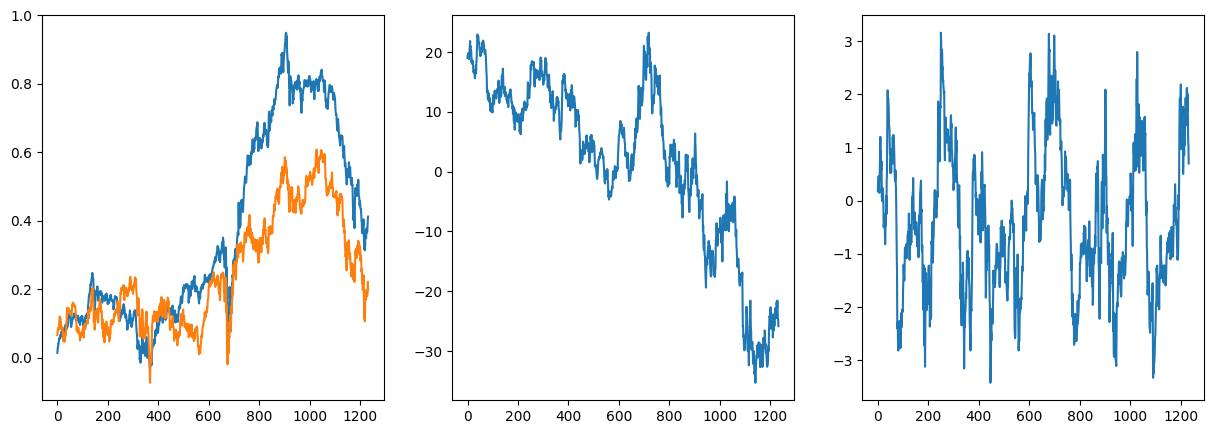

In [7]:
#Visualize Data
fig = plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(df['a1_prod_rets'].values)
plt.plot(df['a2_prod_rets'].values)

plt.subplot(1,3,2)
plt.plot(df['Spread'].values)

plt.subplot(1,3,3)
plt.plot(df['zScore'].values)


In [8]:
#Add Target
future_step = 1
df['TARGET'] = 0
df.loc[df['Spread'].shift(-future_step)>0,'TARGET'] = 1
df.dropna(inplace = True)
df.head(5)

,Asset1,Asset2,Spread,zScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,a1_sum_rets,a2_sum_rets,TARGET
30,30.031599,101.611946,19.010895,0.178721,0.004421,-0.008098,-0.000801,0.002419,0.013692,0.065260,0.013692,0.065260,1
31,30.171650,102.290588,19.482383,0.343656,0.004653,0.006657,-0.000064,0.002840,0.018344,0.071917,0.023842,0.079865,1
32,30.498104,102.946281,19.076434,0.219473,0.010762,0.006390,0.000678,0.003287,0.029106,0.078306,0.036786,0.099948,1
33,30.528391,103.733109,19.785574,0.462258,0.000993,0.007614,0.000382,0.003455,0.030099,0.085920,0.030737,0.102475,1
34,30.838766,103.733109,19.293594,0.305879,0.010115,0.000000,0.001102,0.003187,0.040214,0.085920,0.035127,0.084648,1


In [9]:
#Split X and y
X_data = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
len(X_data),len(y)

(1233, 1233)

In [10]:
set(df.TARGET)

{0, 1}

(array([447.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 786.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

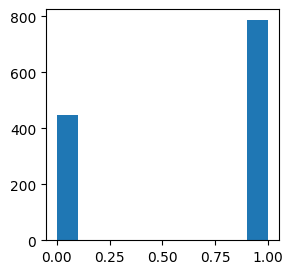

In [11]:
figsize = plt.figure(figsize=(3,3))
plt.hist(df.TARGET)

In [12]:
#Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_data)
X[:2]

array([[-1.10827623, -1.04117537,  1.20243102,  0.41017179,  0.28632711,
        -0.51998219, -0.35600636,  0.73655035, -1.27082394, -1.11116519,
         0.06523649,  0.80801143],
       [-1.09767872, -1.00905511,  1.23530279,  0.53346881,  0.30252398,
         0.41581427, -0.11357727,  0.87022081, -1.254236  , -1.07056091,
         0.1994248 ,  1.00050002]])

### Dataload Structuring

In [13]:
# Dataset Class
class dataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X, dtype = torch.float)
        self.y = torch.tensor(y, dtype = torch.float)
        self.length = self.X.shape[0]
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X,y)
trainloader = DataLoader(trainset,batch_size = 64, shuffle = False)

In [14]:
#Review X Data
trainloader.dataset.X[:2]

tensor([[-1.1083, -1.0412,  1.2024,  0.4102,  0.2863, -0.5200, -0.3560,  0.7366,
         -1.2708, -1.1112,  0.0652,  0.8080],
        [-1.0977, -1.0091,  1.2353,  0.5335,  0.3025,  0.4158, -0.1136,  0.8702,
         -1.2542, -1.0706,  0.1994,  1.0005]])

In [15]:
#Review y Data
trainloader.dataset.y[:10]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Build Neural Net

In [29]:
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x= torch.sigmoid(self.fc3(x))
        return x

In [30]:
X.shape

(1233, 12)

### Train Neural Net

In [38]:
#Hyperparams
lr = 0.01
epochs = 1000

# Model, Optimizer, Loss

model = Net(input_shape = X.shape[1])

In [39]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
loss_fn = nn.BCELoss()

In [40]:
# Forward Loop
losses = []
accur = []
for i in range(epochs):
    for j, (X_train,y_train) in enumerate(trainloader):

        #Calculate output
        output = model(X_train)

        #Calculate loss
        loss = loss_fn(output, y_train.reshape(-1,1))

        #Calculate accuracy
        predicted = model(torch.tensor(X, dtype = torch.float32))
        acc = (predicted.detach().numpy().round() == y).mean()

        #Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Print Results
        if i % 10 ==0:
            losses.append(loss)
            accur.append(acc)
            print(f"Epoch: {i}, Loss: {loss}, Accuracy: {acc}")
            

Epoch: 0, Loss: 0.7165271043777466, Accuracy: 0.45506874021978716
Epoch: 0, Loss: 0.5989149808883667, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.48723286390304565, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.3867928385734558, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.2954797148704529, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.15796947479248047, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.08017600327730179, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.14921411871910095, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 2.1913094520568848, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.6093865036964417, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.3063502907752991, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.03258633241057396, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 0.6104549169540405, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 1.3982162475585938, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 1.343498945236206, Accuracy: 0.6374695863746959
Epoch: 0, Loss: 1.27